In [1]:
from medmnist import PneumoniaMNIST
from medmnist import INFO

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np
from pennylane import draw_mpl
from pennylane.qnn import TorchLayer

In [2]:
def load_data(batch_size=32, train_fraction=0.2, val_fraction=1.0, test_fraction=1.0):
    data_flag = "pneumoniamnist"
    info = INFO[data_flag]
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


    if train_fraction < 1.0:
        n_train = int(len(train_dataset) * train_fraction)
        indices = np.random.choice(len(train_dataset), n_train, replace=False)
        train_dataset = Subset(train_dataset, indices)

    if val_fraction < 1.0:
        n_val = int(len(val_dataset) * val_fraction)
        indices = np.random.choice(len(val_dataset), n_val, replace=False)
        val_dataset = Subset(val_dataset, indices)

    if test_fraction < 1.0:
        n_test = int(len(test_dataset) * test_fraction)
        indices = np.random.choice(len(test_dataset), n_test, replace=False)
        test_dataset = Subset(test_dataset, indices)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

In [3]:
def extract_xy_from_loader(dataloader):
    x_all = []
    y_all = []

    for x_batch, y_batch in dataloader:
        x_all.append(x_batch.view(x_batch.size(0), -1))
        y_all.append(y_batch)

    x = torch.cat(x_all, dim=0)
    y = torch.cat(y_all, dim=0)

    return x, y

In [4]:
def sample_batch(dataloader, n_samples=8, device='cpu'):
    for x, y in dataloader:
        x = x.view(x.size(0), -1).to(device)
        y = y.to(device)

        if n_samples <= x.size(0):
            return x[:n_samples], y[:n_samples]
        else:
            raise ValueError(f"Batch size {x.size(0)} is smaller than requested {n_samples}")

In [5]:
def show_images_batch(x_batch, y_batch, n_cols=4):
    n_samples = x_batch.size(0)
    n_rows = (n_samples + n_cols -1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    if x_batch.ndim == 2:
        x_batch = x_batch.view(n_samples, 1, 4, 1)

    axes = axes.flatten() if n_samples > 1 else [axes]

    for i in range(n_samples):
        image = x_batch[i].squeeze().cpu().numpy()
        label = y_batch[i].item()
        axes[i].imshow(image, cmap='gray', aspect="auto")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
class PCAEncoder:
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)
        self.fitted = False

    def fit(self, dataloader):
        all_images = []
        for x, _ in dataloader:
            x = x.view(x.size(0), -1)
            all_images.append(x)
        X = torch.cat(all_images, dim=0).numpy()
        self.pca.fit(X)
        self.fitted = True

    # def transform(self, x):
    #     if not self.fitted:
    #         raise RuntimeError("PCAEncoder must be fit before calling transform.")
    #     x = x.view(x.size(0), -1).numpy()
    #     return torch.tensor(self.pca.transform(x), dtype=torch.float32)

    def transform(self, dataloader):
        if not self.fitted:
            raise RuntimeError("PCA Encoder mus be fit before calling transform.")

        all_transformed = []
        all_labels = []
        for x, y in dataloader:
            x = x.view(x.size(0), -1).numpy()
            x_transformed = self.pca.transform(x)
            all_transformed.append(torch.tensor(x_transformed, dtype=torch.float32))
            all_labels.append(y)

        x_all = torch.cat(all_transformed, dim=0)
        y_all = torch.cat(all_labels, dim=0)
        return x_all, y_all

        # return torch.cat(all_transformed, dim=0)

    # def fit_transform(self, dataloader):
    #     self.fit(dataloader)
    #     return self.transform(dataloader)

In [7]:
train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.1)
# train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(batch_size=32, train_fraction=0.5)

In [8]:
encoder = PCAEncoder(n_components=4)
encoder.fit(train_loader)

x_train_encoded, y_train_tensor = encoder.transform(train_loader)
x_val_encoded, y_val_tensor = encoder.transform(val_loader)
x_test_encoded, y_test_tensor = encoder.transform(test_loader)

In [9]:
def visualize_umap(X, y):
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.grid(True)
    plt.show()

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


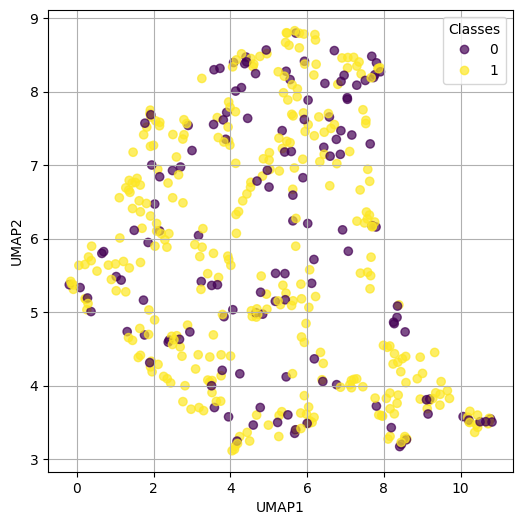

In [10]:
y_train = torch.cat([y for _, y in train_loader], dim=0)

visualize_umap(x_train_encoded.numpy(), y_train.numpy())

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


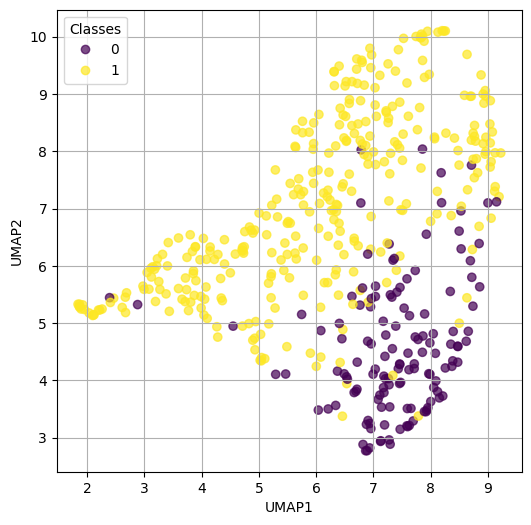

In [11]:
x_train_raw, y_train_raw = extract_xy_from_loader(train_loader)

visualize_umap(x_train_raw.numpy(), y_train_raw.numpy())

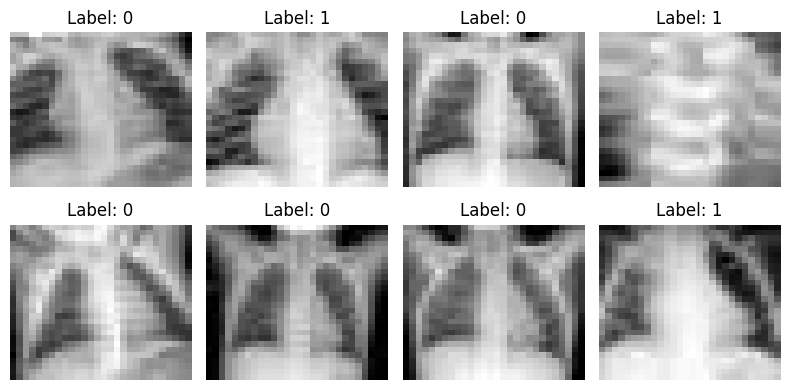

In [12]:
#original images
x_batch, y_batch = sample_batch(train_loader, n_samples=8)
show_images_batch(x_batch.view(-1, 1, 28, 28), y_batch)

/tmp/ipykernel_284517/3624222051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)


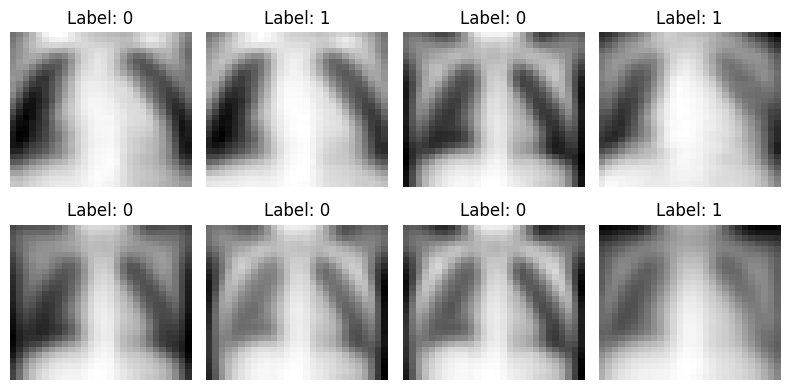

In [13]:
#pca encoded images
temp_dataset = TensorDataset(x_batch, y_batch)
temp_loader = DataLoader(temp_dataset, batch_size=8, shuffle=False)

x_encoded, y_encoded = encoder.transform(temp_loader)
x_reconstructed = encoder.pca.inverse_transform(x_encoded)

x_reconstructed = torch.tensor(x_reconstructed).view(-1, 1, 28, 28)

show_images_batch(x_reconstructed, y_batch)

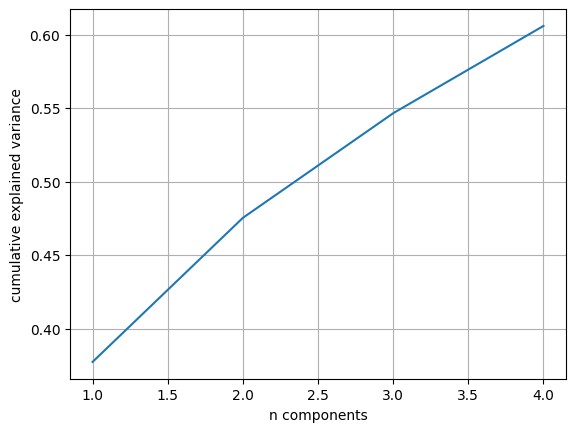

In [14]:
plt.plot(np.arange(1, len(encoder.pca.explained_variance_ratio_) + 1),
         np.cumsum(encoder.pca.explained_variance_ratio_))
plt.xlabel("n components")
plt.ylabel("cumulative explained variance")
plt.grid(True)
plt.show()

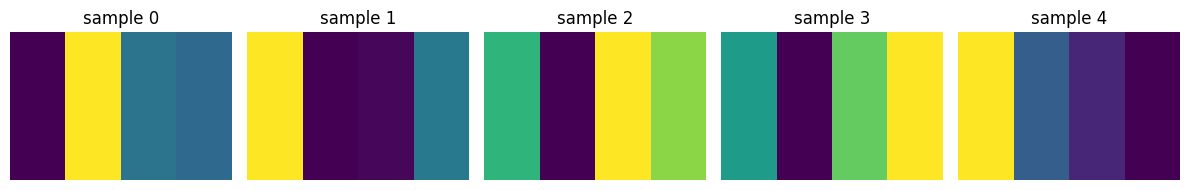

In [15]:
plt.figure(figsize=(12, 2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.heatmap(x_train_encoded[i].unsqueeze(0), cmap="viridis", cbar=False)
    plt.title(f"sample {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
n_qumodes = 4
dev = qml.device("default.gaussian", wires=n_qumodes, shots=None)
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def cv_qcnn(inputs, weights):
    for i in range(n_qumodes):
        qml.Displacement(inputs[i], 0.0, wires=i)

    for l in range(weights.shape[0]):
        for i in range(n_qumodes):
            qml.Rotation(weights[l, i, 0], wires=i)
            qml.Squeezing(weights[l, i, 1], 0.0, wires=i)
        qml.Beamsplitter(weights[l, 0, 2], weights[l, 0, 3], wires=[0, 1])


    return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]


In [17]:

#dummy inputs: n_qumodes
dummy_inputs = torch.zeros(n_qumodes)
#dummy weights: number of layers, n_qumodes, n_input_features

dummy_weights = torch.zeros((2, n_qumodes, 6))

drawer = qml.draw(cv_qcnn)
print(drawer(dummy_inputs, dummy_weights))

0: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╭BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╭BS(0.00,0.00)─┤
1: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)─╰BS(0.00,0.00)──R(0.00)───────S(0.00,0.00)─╰BS(0.00,0.00)─┤
2: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤
3: ──D(0.00,0.00)──R(0.00)──S(0.00,0.00)──R(0.00)────────S(0.00,0.00)──────────────────────────────┤

   <X>
   <X>
   <X>
   <X>


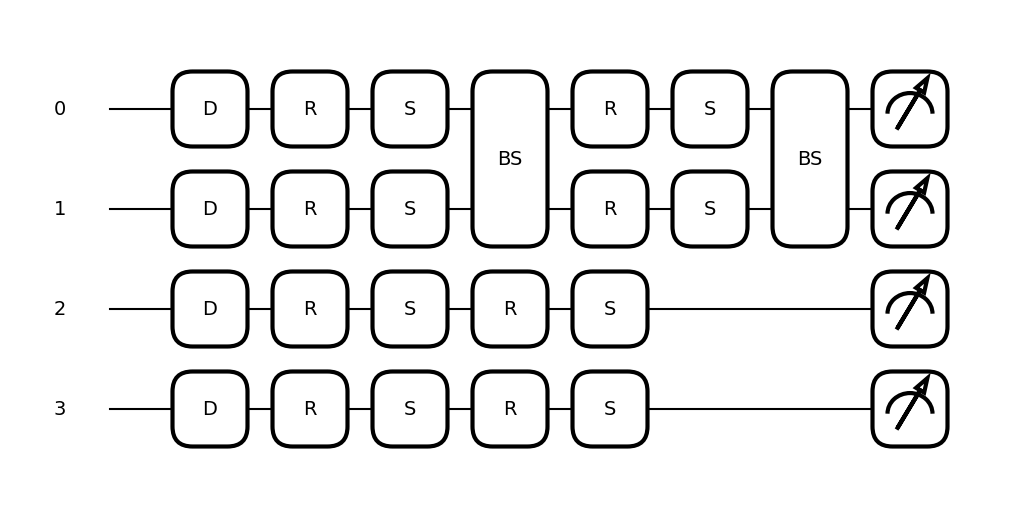

In [18]:
fig, ax = draw_mpl(cv_qcnn)(dummy_inputs, dummy_weights)
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)
x_test_scaled = scaler.fit_transform(x_test_encoded)

x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

In [20]:
print(x_train_tensor[0])

tensor([-0.0013,  0.6224,  0.1629, -0.0672])


In [21]:
print(x_train_tensor[0].shape)

torch.Size([4])


In [22]:
weights = np.random.rand(2, n_qumodes, 4)
output = cv_qcnn(x_train_tensor[0], weights)

/home/dalopezm/miniconda3/envs/qml-dv-cv/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


In [23]:
print(output)

tensor([-0.3134,  0.0653, -0.0947, -0.0440], dtype=torch.float64)


In [24]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
class QuantumWrapper(nn.Module):
    def __init__(self, n_qumodes=4, n_classes=2, hidden_dim=16):
        super().__init__()

        weight_shapes = {"weights": (2, n_qumodes, 4)}

        # self.quantum = TorchLayer(
            # qml.qnode(dev, interface="torch", diff_method="parameter-shift")(cv_qcnn),
            # weight_shapes
        # )

        qnode = qml.QNode(cv_qcnn, dev, interface="torch", diff_method="parameter-shift")

        self.quantum = TorchLayer(qnode, weight_shapes)
        
        self.head = nn.Sequential(
            nn.Linear(n_qumodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        quantum_outs = torch.stack([self.quantum(sample) for sample in x])
        return self.head(quantum_outs)

In [26]:
class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.head(x)

In [27]:
# def train_v2(model, dataloader, optimizer, loss_fn, device, results_path, model_path):
def train_v2(model, dataloader, optimizer, loss_fn, device):

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    model.train()

    total_loss = 0
    total_samples = 0
    correct = 0
    all_labels = []
    all_preds = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}",
        })

        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics

In [28]:
# def train(model, dataloader, optimizer, loss_fn, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     for x_batch, y_batch in progress_bar:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         # print(x_batch.shape)
#         optimizer.zero_grad()
#         logits = model(x_batch)
#         y_batch = y_batch.view(-1).long()
#         # print(logits.shape)
#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x_batch.size(0)
#         pred = logits.argmax(dim=1)
#         correct += (pred == y_batch).sum().item()
#         total_samples += x_batch.size(0)

#         progress_bar.set_postfix({
#             "loss": f"{loss.item():.4f}",
#             "acc": f"{(correct/total_samples):.4f}"
#         })

#     avg_loss = total_loss / total_samples
#     avg_acc = correct / total_samples
#     return avg_loss, avg_acc

In [29]:
def evaluate_v2(model, dataloader, loss_fn, device):
    model.eval()

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []
    all_probs = []

        
    for x_batch, y_batch in progress_bar:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.view(-1).long()
        loss = loss_fn(outputs, y_batch)

        total_loss += loss.item() * x_batch.size(0)
        probs = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total_samples += x_batch.size(0)

        progress_bar.set_postfix({
            "loss": f"{total_loss/total_samples:.4f}",
            "acc": f"{(correct/total_samples):.4f}"
        })

        all_probs.extend(probs.cpu().detach().numpy())
        all_preds.extend(pred.cpu().detach().numpy())
        all_labels.extend(y_batch.cpu().detach().numpy())


    avg_loss = total_loss / total_samples
    avg_acc = correct / total_samples
    avg_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_f1 = recall_score(all_labels, all_preds, average="weighted")

    metrics = classification_report(
        all_labels,
        all_preds,
        output_dict = True,
        zero_division=0
    )

    return avg_loss, avg_acc, avg_precision, avg_recall, avg_f1, metrics, all_preds, all_probs, all_labels
    

In [30]:
from sklearn.model_selection import StratifiedKFold

def run_kfold_training(model_class, dataset, optimizer, criterion, classical=False, k=5, num_epochs=10, seed=42):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    labels = np.array([label for _, label in dataset])

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n Fold {fold+1}/{k}")

        all_train_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        all_val_metrics = {"acc": [], "loss": [], "prec": [], "rec": [], "f1": []}
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

        # model = model_class().to(device)

        for epoch in range(num_epochs):
            train_loss, train_acc, train_prec, train_rec, train_f1, _ = train_v2(model_class, train_loader, optimizer, criterion, device)
            val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _, _ = evaluate_v2(model_class, val_loader, criterion, device)



            all_train_metrics["acc"].append(train_acc)
            all_train_metrics["loss"].append(train_loss)
            all_train_metrics["prec"].append(train_prec)
            all_train_metrics["rec"].append(train_rec)
            all_train_metrics["f1"].append(train_f1)

            all_val_metrics["acc"].append(val_acc)
            all_val_metrics["loss"].append(val_loss)
            all_val_metrics["prec"].append(val_prec)
            all_val_metrics["rec"].append(val_rec)
            all_val_metrics["f1"].append(val_f1)

            tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
            tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

        if classical:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_best.pth")

        else:
            with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "wb") as f:
                pickle.dump((all_train_metrics, all_val_metrics), f)
    
            torch.save(model_class.state_dict(), f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_best.pth")

    # return all_train_metrics, all_val_metrics

In [31]:
def plot_metric_with_std(metric_name, train_folds, val_folds, epochs):
    train_array = np.array(train_folds[metric_name])
    val_array = np.array(val_folds[metric_name])

    train_mean = np.mean(train_array, axis=0)
    train_std = np.std(train_array, axis=0)
    val_mean = np.mean(val_array, axis=0)
    val_std = np.std(val_array, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_mean, label="Train", color="blue", marker="o")
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

    plt.plot(epochs, val_mean, label="Validation", color="green", marker="^")
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

    plt.xlabel("Epochs")
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "metric": metric_name,
        "train_name": float(train_mean[-1]),
        "train_std": float(train_std[-1]),
        "val_mean": float(val_mean[-1]),
        "val_std": float(val_std[-1]),
    }

In [32]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_correct = 0
#     total_samples = 0

#     progress_bar = tqdm(dataloader, desc="Training", leave=True)

#     with torch.no_grad():
#         for x_batch, y_batch in progress_bar:
#             x_batch = x_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(x_batch)
#             y_batch = y_batch.view(-1).long()
#             loss = criterion(outputs, y_batch)

#             total_loss += loss.item() * x_batch.size(0)
#             pred = outputs.argmax(dim=1)
#             correct += (pred == y_batch).sum().item()
#             total_samples += x_batch.size(0)

#             progress_bar.set_postfix({
#                 "loss": f"{loss.item():.4f}",
#                 "acc": f"{(correct/total_samples):.4f}"
#             })

#         avg_loss = total_loss / total_samples
#         avg_acc = correct / total_samples
#         return avg_loss, avg_acc

In [33]:
epochs = 10
device = "cpu"
cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)

optimizer = torch.optim.Adam(cv_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
import pickle
summary(cv_model)

Layer (type:depth-idx)                   Param #
QuantumWrapper                           --
├─TorchLayer: 1-1                        32
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 146
Trainable params: 146
Non-trainable params: 0

In [34]:
run_kfold_training(cv_model, train_dataset, optimizer, criterion, classical=False, k=3, num_epochs=10, seed=42)


 Fold 1/3


Training: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s, loss=0.3344, acc=0.8662]


Train loss: 0.2944 | Train acc: 0.8786 | Train rec: 0.8786 | Train prec: 0.8828 | Train f1: 0.8801
Val loss: 0.3344 | Val acc: 0.8662 | Val rec: 0.8662 | Val prec: 0.8672 | Val f1: 0.8662


Training: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s, loss=0.3116, acc=0.8726]


Train loss: 0.2629 | Train acc: 0.8818 | Train rec: 0.8818 | Train prec: 0.8853 | Train f1: 0.8831
Val loss: 0.3116 | Val acc: 0.8726 | Val rec: 0.8726 | Val prec: 0.8726 | Val f1: 0.8726


Training: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s, loss=0.3193, acc=0.8790]


Train loss: 0.2585 | Train acc: 0.8850 | Train rec: 0.8850 | Train prec: 0.8868 | Train f1: 0.8857
Val loss: 0.3193 | Val acc: 0.8790 | Val rec: 0.8790 | Val prec: 0.8782 | Val f1: 0.8790


Training: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s, loss=0.3260, acc=0.8726]


Train loss: 0.2544 | Train acc: 0.8850 | Train rec: 0.8850 | Train prec: 0.8868 | Train f1: 0.8857
Val loss: 0.3260 | Val acc: 0.8726 | Val rec: 0.8726 | Val prec: 0.8712 | Val f1: 0.8726


Training: 100%|██████████| 5/5 [00:00<00:00, 10.66it/s, loss=0.3228, acc=0.8662]


Train loss: 0.2539 | Train acc: 0.8850 | Train rec: 0.8850 | Train prec: 0.8868 | Train f1: 0.8857
Val loss: 0.3228 | Val acc: 0.8662 | Val rec: 0.8662 | Val prec: 0.8654 | Val f1: 0.8662


Training: 100%|██████████| 5/5 [00:00<00:00, 10.64it/s, loss=0.3207, acc=0.8662]


Train loss: 0.2533 | Train acc: 0.8818 | Train rec: 0.8818 | Train prec: 0.8841 | Train f1: 0.8827
Val loss: 0.3207 | Val acc: 0.8662 | Val rec: 0.8662 | Val prec: 0.8654 | Val f1: 0.8662


Training: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s, loss=0.3194, acc=0.8790]


Train loss: 0.2512 | Train acc: 0.8850 | Train rec: 0.8850 | Train prec: 0.8868 | Train f1: 0.8857
Val loss: 0.3194 | Val acc: 0.8790 | Val rec: 0.8790 | Val prec: 0.8782 | Val f1: 0.8790


Training: 100%|██████████| 5/5 [00:00<00:00, 10.57it/s, loss=0.3159, acc=0.8790]


Train loss: 0.2503 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8894 | Train f1: 0.8887
Val loss: 0.3159 | Val acc: 0.8790 | Val rec: 0.8790 | Val prec: 0.8782 | Val f1: 0.8790


Training: 100%|██████████| 5/5 [00:00<00:00, 10.64it/s, loss=0.3181, acc=0.8726]


Train loss: 0.2500 | Train acc: 0.8882 | Train rec: 0.8882 | Train prec: 0.8894 | Train f1: 0.8887
Val loss: 0.3181 | Val acc: 0.8726 | Val rec: 0.8726 | Val prec: 0.8712 | Val f1: 0.8726


Training: 100%|██████████| 5/5 [00:00<00:00,  7.30it/s, loss=0.3207, acc=0.8599]


Train loss: 0.2479 | Train acc: 0.8914 | Train rec: 0.8914 | Train prec: 0.8922 | Train f1: 0.8917
Val loss: 0.3207 | Val acc: 0.8599 | Val rec: 0.8599 | Val prec: 0.8571 | Val f1: 0.8599

 Fold 2/3


Training: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s, loss=0.2402, acc=0.8917]


Train loss: 0.2881 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8743 | Train f1: 0.8748
Val loss: 0.2402 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s, loss=0.2454, acc=0.8917]


Train loss: 0.2820 | Train acc: 0.8786 | Train rec: 0.8786 | Train prec: 0.8786 | Train f1: 0.8786
Val loss: 0.2454 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s, loss=0.2470, acc=0.8917]


Train loss: 0.2853 | Train acc: 0.8818 | Train rec: 0.8818 | Train prec: 0.8814 | Train f1: 0.8816
Val loss: 0.2470 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.2406, acc=0.8917]


Train loss: 0.2846 | Train acc: 0.8786 | Train rec: 0.8786 | Train prec: 0.8779 | Train f1: 0.8782
Val loss: 0.2406 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.2408, acc=0.8917]


Train loss: 0.2819 | Train acc: 0.8786 | Train rec: 0.8786 | Train prec: 0.8773 | Train f1: 0.8778
Val loss: 0.2408 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.53it/s, loss=0.2425, acc=0.8917]


Train loss: 0.2810 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8737 | Train f1: 0.8743
Val loss: 0.2425 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8945 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s, loss=0.2411, acc=0.8917]


Train loss: 0.2802 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8737 | Train f1: 0.8743
Val loss: 0.2411 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8925 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.66it/s, loss=0.2419, acc=0.8917]


Train loss: 0.2807 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8737 | Train f1: 0.8743
Val loss: 0.2419 | Val acc: 0.8917 | Val rec: 0.8917 | Val prec: 0.8925 | Val f1: 0.8917


Training: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.2405, acc=0.8981]


Train loss: 0.2791 | Train acc: 0.8754 | Train rec: 0.8754 | Train prec: 0.8737 | Train f1: 0.8743
Val loss: 0.2405 | Val acc: 0.8981 | Val rec: 0.8981 | Val prec: 0.8981 | Val f1: 0.8981


Training: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.2405, acc=0.8981]


Train loss: 0.2780 | Train acc: 0.8722 | Train rec: 0.8722 | Train prec: 0.8699 | Train f1: 0.8704
Val loss: 0.2405 | Val acc: 0.8981 | Val rec: 0.8981 | Val prec: 0.8981 | Val f1: 0.8981

 Fold 3/3


Training: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s, loss=0.2433, acc=0.8910]


Train loss: 0.2762 | Train acc: 0.8726 | Train rec: 0.8726 | Train prec: 0.8707 | Train f1: 0.8713
Val loss: 0.2433 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8904 | Val f1: 0.8910


Training: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s, loss=0.2447, acc=0.8974]


Train loss: 0.2749 | Train acc: 0.8822 | Train rec: 0.8822 | Train prec: 0.8800 | Train f1: 0.8802
Val loss: 0.2447 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.2446, acc=0.8974]


Train loss: 0.2739 | Train acc: 0.8854 | Train rec: 0.8854 | Train prec: 0.8833 | Train f1: 0.8832
Val loss: 0.2446 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00,  7.28it/s, loss=0.2430, acc=0.8974]


Train loss: 0.2756 | Train acc: 0.8822 | Train rec: 0.8822 | Train prec: 0.8800 | Train f1: 0.8802
Val loss: 0.2430 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=0.2432, acc=0.8974]


Train loss: 0.2770 | Train acc: 0.8822 | Train rec: 0.8822 | Train prec: 0.8800 | Train f1: 0.8802
Val loss: 0.2432 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s, loss=0.2440, acc=0.8910]


Train loss: 0.2745 | Train acc: 0.8854 | Train rec: 0.8854 | Train prec: 0.8833 | Train f1: 0.8832
Val loss: 0.2440 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8904 | Val f1: 0.8910


Training: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s, loss=0.2426, acc=0.8910]


Train loss: 0.2776 | Train acc: 0.8790 | Train rec: 0.8790 | Train prec: 0.8768 | Train f1: 0.8772
Val loss: 0.2426 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8904 | Val f1: 0.8910


Training: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s, loss=0.2424, acc=0.8974]


Train loss: 0.2743 | Train acc: 0.8822 | Train rec: 0.8822 | Train prec: 0.8800 | Train f1: 0.8802
Val loss: 0.2424 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s, loss=0.2412, acc=0.8974]


Train loss: 0.2780 | Train acc: 0.8854 | Train rec: 0.8854 | Train prec: 0.8833 | Train f1: 0.8832
Val loss: 0.2412 | Val acc: 0.8974 | Val rec: 0.8974 | Val prec: 0.8964 | Val f1: 0.8974


Training: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s, loss=0.2432, acc=0.8910]

Train loss: 0.2749 | Train acc: 0.8822 | Train rec: 0.8822 | Train prec: 0.8800 | Train f1: 0.8802
Val loss: 0.2432 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.8904 | Val f1: 0.8910


In [35]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

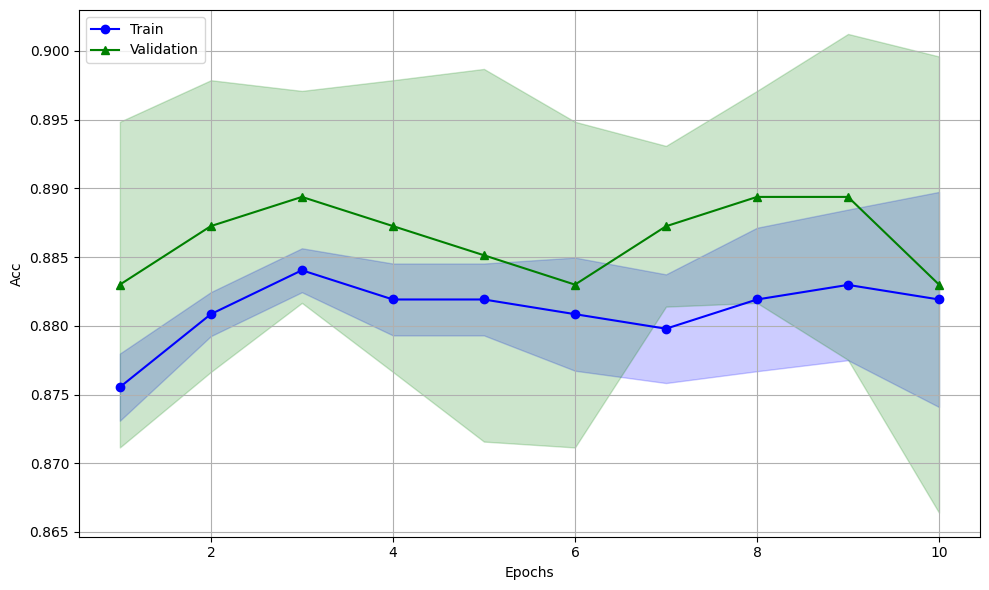

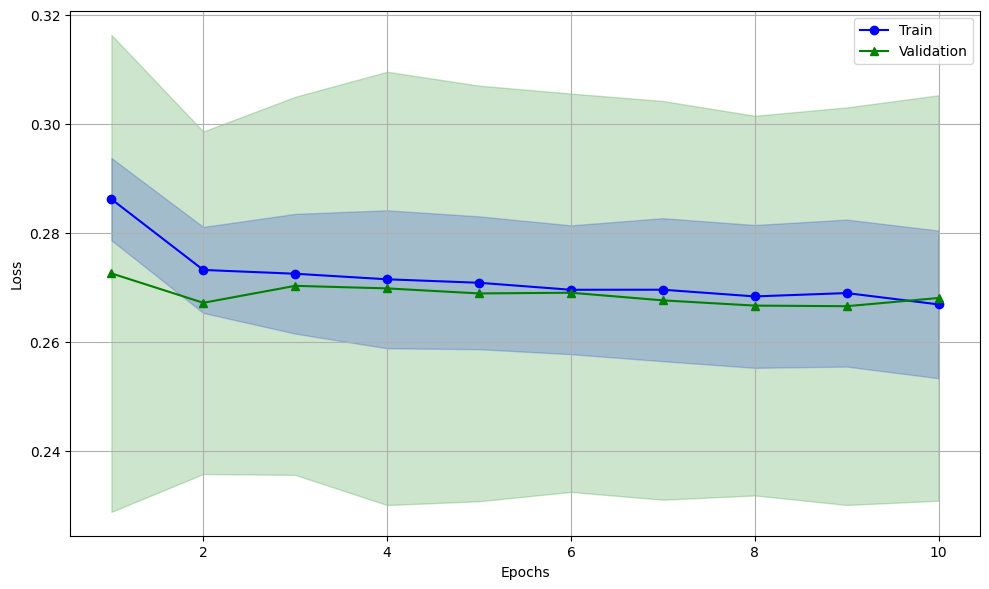

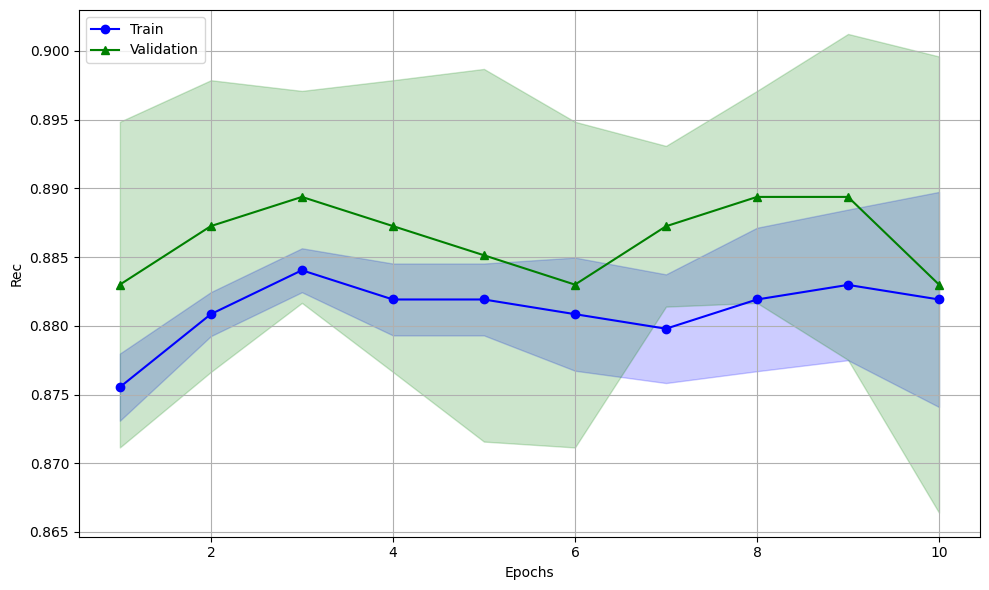

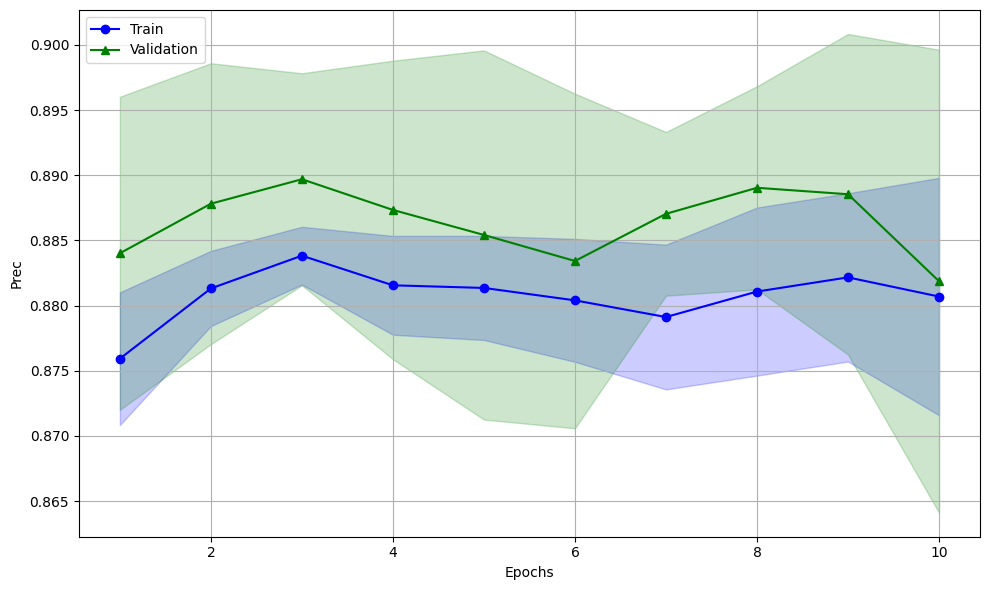

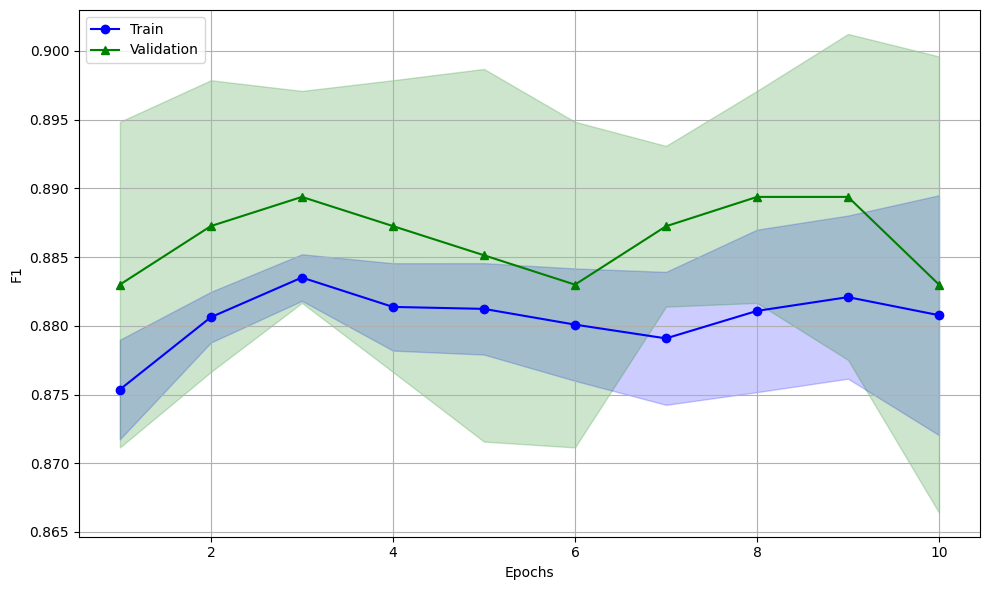

In [37]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}
import json

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range)
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [38]:
# train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     train_loss, train_acc, train_prec, train_rec, train_f1, train_report = train_v2(cv_model, train_loader, optimizer, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, val_report, val_preds, val_probs, val_labels = evaluate_v2(cv_model, val_loader, criterion, device)

#     train_metrics["acc"].append(train_acc)
#     train_metrics["loss"].append(train_loss)
#     train_metrics["rec"].append(train_rec)
#     train_metrics["prec"].append(train_prec)
#     train_metrics["f1"].append(train_f1)
    
#     val_metrics["acc"].append(val_acc)
#     val_metrics["loss"].append(val_loss)
#     val_metrics["rec"].append(val_rec)
#     val_metrics["prec"].append(val_prec)
#     val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(cv_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth")
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")

# import json
# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_train_metrics.json", "w") as f:
#     json.dump(train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_val_metrics.json", "w") as f:
#     json.dump(val_metrics, f, indent=4)

In [39]:
# epochs = range(1, len(train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [40]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 2 with val_f1 = 0.8981


In [56]:
device = "cpu"
test_cv_model = QuantumWrapper(n_qumodes=4, n_classes=2, hidden_dim=16).to(device)
# test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_model_best.pth"))
test_cv_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/cv_fold_2_best.pth"))
test_cv_model.to(device)

test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_cv_model, test_loader, criterion, device)

test_metrics["acc"].append(test_acc)
test_metrics["loss"].append(test_loss)
test_metrics["rec"].append(test_rec)
test_metrics["prec"].append(test_prec)
test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/cv_test_metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=4)

Training: 100%|████████| 20/20 [00:02<00:00,  9.51it/s, loss=0.4891, acc=0.7692]

Test loss: 0.4891 | Test acc: 0.7692 | Test rec: 0.7692 | Test prec: 0.8112 | Test f1: 0.7692


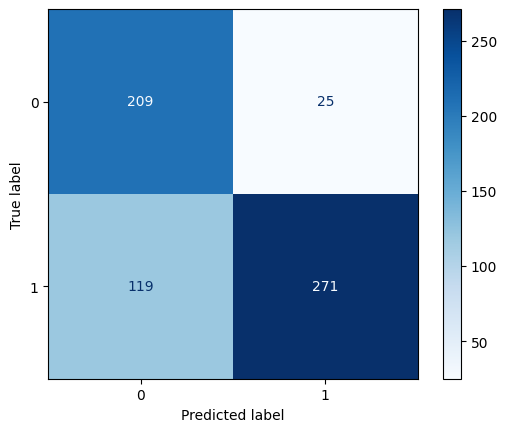

In [57]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.9002629848783694


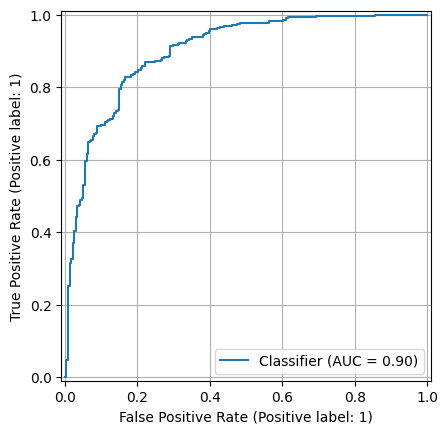

In [58]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

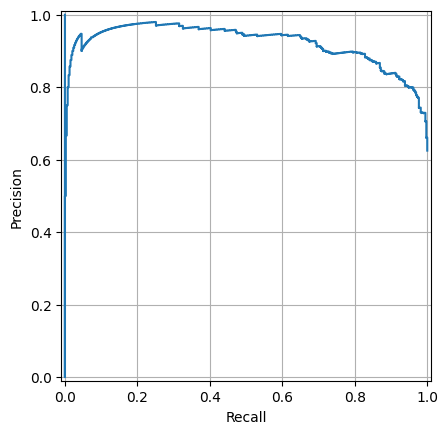

In [59]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()

## CLASSICAL MODEL

In [45]:
epochs = 10
# epochs = 30
device = "cpu"
classical_model = ClassicalModel()

optimizer = torch.optim.Adam(classical_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

from torchinfo import summary
summary(classical_model)

Layer (type:depth-idx)                   Param #
ClassicalModel                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       34
Total params: 114
Trainable params: 114
Non-trainable params: 0

In [46]:
run_kfold_training(classical_model, train_dataset, optimizer, criterion, classical=True, k=3, num_epochs=10, seed=42)


 Fold 1/3


Training: 100%|█████████| 5/5 [00:00<00:00, 288.94it/s, loss=0.6216, acc=0.7197]


Train loss: 0.6295 | Train acc: 0.7220 | Train rec: 0.7220 | Train prec: 0.8001 | Train f1: 0.6147
Val loss: 0.6216 | Val acc: 0.7197 | Val rec: 0.7197 | Val prec: 0.7988 | Val f1: 0.7197


Training: 100%|█████████| 5/5 [00:00<00:00, 271.55it/s, loss=0.6092, acc=0.7134]


Train loss: 0.6162 | Train acc: 0.7188 | Train rec: 0.7188 | Train prec: 0.7984 | Train f1: 0.6076
Val loss: 0.6092 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 246.12it/s, loss=0.5978, acc=0.7134]


Train loss: 0.6039 | Train acc: 0.7157 | Train rec: 0.7157 | Train prec: 0.7968 | Train f1: 0.6003
Val loss: 0.5978 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 271.73it/s, loss=0.5865, acc=0.7134]


Train loss: 0.5927 | Train acc: 0.7125 | Train rec: 0.7125 | Train prec: 0.5076 | Train f1: 0.5928
Val loss: 0.5865 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 260.45it/s, loss=0.5757, acc=0.7134]


Train loss: 0.5811 | Train acc: 0.7125 | Train rec: 0.7125 | Train prec: 0.5076 | Train f1: 0.5928
Val loss: 0.5757 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 254.50it/s, loss=0.5651, acc=0.7134]


Train loss: 0.5697 | Train acc: 0.7125 | Train rec: 0.7125 | Train prec: 0.5076 | Train f1: 0.5928
Val loss: 0.5651 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 264.14it/s, loss=0.5543, acc=0.7134]


Train loss: 0.5584 | Train acc: 0.7125 | Train rec: 0.7125 | Train prec: 0.5076 | Train f1: 0.5928
Val loss: 0.5543 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 270.79it/s, loss=0.5434, acc=0.7134]


Train loss: 0.5469 | Train acc: 0.7157 | Train rec: 0.7157 | Train prec: 0.7968 | Train f1: 0.6003
Val loss: 0.5434 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 303.69it/s, loss=0.5323, acc=0.7134]


Train loss: 0.5356 | Train acc: 0.7157 | Train rec: 0.7157 | Train prec: 0.7968 | Train f1: 0.6003
Val loss: 0.5323 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 316.82it/s, loss=0.5213, acc=0.7134]


Train loss: 0.5237 | Train acc: 0.7157 | Train rec: 0.7157 | Train prec: 0.7968 | Train f1: 0.6003
Val loss: 0.5213 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134

 Fold 2/3


Training: 100%|█████████| 5/5 [00:00<00:00, 246.10it/s, loss=0.5046, acc=0.7134]


Train loss: 0.5145 | Train acc: 0.7188 | Train rec: 0.7188 | Train prec: 0.7984 | Train f1: 0.6076
Val loss: 0.5046 | Val acc: 0.7134 | Val rec: 0.7134 | Val prec: 0.5089 | Val f1: 0.7134


Training: 100%|█████████| 5/5 [00:00<00:00, 251.25it/s, loss=0.4929, acc=0.7197]


Train loss: 0.5036 | Train acc: 0.7252 | Train rec: 0.7252 | Train prec: 0.8017 | Train f1: 0.6218
Val loss: 0.4929 | Val acc: 0.7197 | Val rec: 0.7197 | Val prec: 0.7988 | Val f1: 0.7197


Training: 100%|█████████| 5/5 [00:00<00:00, 309.35it/s, loss=0.4815, acc=0.7261]


Train loss: 0.4922 | Train acc: 0.7348 | Train rec: 0.7348 | Train prec: 0.8068 | Train f1: 0.6422
Val loss: 0.4815 | Val acc: 0.7261 | Val rec: 0.7261 | Val prec: 0.8021 | Val f1: 0.7261


Training: 100%|█████████| 5/5 [00:00<00:00, 260.95it/s, loss=0.4703, acc=0.7325]


Train loss: 0.4807 | Train acc: 0.7348 | Train rec: 0.7348 | Train prec: 0.8068 | Train f1: 0.6422
Val loss: 0.4703 | Val acc: 0.7325 | Val rec: 0.7325 | Val prec: 0.8054 | Val f1: 0.7325


Training: 100%|█████████| 5/5 [00:00<00:00, 317.23it/s, loss=0.4589, acc=0.7516]


Train loss: 0.4698 | Train acc: 0.7412 | Train rec: 0.7412 | Train prec: 0.8102 | Train f1: 0.6552
Val loss: 0.4589 | Val acc: 0.7516 | Val rec: 0.7516 | Val prec: 0.8158 | Val f1: 0.7516


Training: 100%|█████████| 5/5 [00:00<00:00, 282.38it/s, loss=0.4473, acc=0.7643]


Train loss: 0.4591 | Train acc: 0.7476 | Train rec: 0.7476 | Train prec: 0.8136 | Train f1: 0.6679
Val loss: 0.4473 | Val acc: 0.7643 | Val rec: 0.7643 | Val prec: 0.8229 | Val f1: 0.7643


Training: 100%|█████████| 5/5 [00:00<00:00, 300.02it/s, loss=0.4361, acc=0.7707]


Train loss: 0.4480 | Train acc: 0.7572 | Train rec: 0.7572 | Train prec: 0.8189 | Train f1: 0.6861
Val loss: 0.4361 | Val acc: 0.7707 | Val rec: 0.7707 | Val prec: 0.8265 | Val f1: 0.7707


Training: 100%|█████████| 5/5 [00:00<00:00, 294.75it/s, loss=0.4250, acc=0.7834]


Train loss: 0.4375 | Train acc: 0.7604 | Train rec: 0.7604 | Train prec: 0.8050 | Train f1: 0.6955
Val loss: 0.4250 | Val acc: 0.7834 | Val rec: 0.7834 | Val prec: 0.8339 | Val f1: 0.7834


Training: 100%|█████████| 5/5 [00:00<00:00, 268.77it/s, loss=0.4140, acc=0.7898]


Train loss: 0.4272 | Train acc: 0.7764 | Train rec: 0.7764 | Train prec: 0.8180 | Train f1: 0.7233
Val loss: 0.4140 | Val acc: 0.7898 | Val rec: 0.7898 | Val prec: 0.8376 | Val f1: 0.7898


Training: 100%|█████████| 5/5 [00:00<00:00, 267.33it/s, loss=0.4033, acc=0.8025]


Train loss: 0.4171 | Train acc: 0.7955 | Train rec: 0.7955 | Train prec: 0.8322 | Train f1: 0.7543
Val loss: 0.4033 | Val acc: 0.8025 | Val rec: 0.8025 | Val prec: 0.8303 | Val f1: 0.8025

 Fold 3/3


Training: 100%|█████████| 5/5 [00:00<00:00, 271.98it/s, loss=0.3916, acc=0.8205]


Train loss: 0.4076 | Train acc: 0.7994 | Train rec: 0.7994 | Train prec: 0.8277 | Train f1: 0.7621
Val loss: 0.3916 | Val acc: 0.8205 | Val rec: 0.8205 | Val prec: 0.8567 | Val f1: 0.8205


Training: 100%|█████████| 5/5 [00:00<00:00, 298.43it/s, loss=0.3815, acc=0.8397]


Train loss: 0.3983 | Train acc: 0.8153 | Train rec: 0.8153 | Train prec: 0.8404 | Train f1: 0.7856
Val loss: 0.3815 | Val acc: 0.8397 | Val rec: 0.8397 | Val prec: 0.8692 | Val f1: 0.8397


Training: 100%|█████████| 5/5 [00:00<00:00, 250.95it/s, loss=0.3716, acc=0.8397]


Train loss: 0.3893 | Train acc: 0.8248 | Train rec: 0.8248 | Train prec: 0.8478 | Train f1: 0.7992
Val loss: 0.3716 | Val acc: 0.8397 | Val rec: 0.8397 | Val prec: 0.8692 | Val f1: 0.8397


Training: 100%|█████████| 5/5 [00:00<00:00, 307.73it/s, loss=0.3624, acc=0.8462]


Train loss: 0.3804 | Train acc: 0.8376 | Train rec: 0.8376 | Train prec: 0.8536 | Train f1: 0.8179
Val loss: 0.3624 | Val acc: 0.8462 | Val rec: 0.8462 | Val prec: 0.8735 | Val f1: 0.8462


Training: 100%|█████████| 5/5 [00:00<00:00, 342.38it/s, loss=0.3537, acc=0.8590]


Train loss: 0.3720 | Train acc: 0.8503 | Train rec: 0.8503 | Train prec: 0.8640 | Train f1: 0.8345
Val loss: 0.3537 | Val acc: 0.8590 | Val rec: 0.8590 | Val prec: 0.8823 | Val f1: 0.8590


Training: 100%|█████████| 5/5 [00:00<00:00, 264.49it/s, loss=0.3452, acc=0.8654]


Train loss: 0.3641 | Train acc: 0.8567 | Train rec: 0.8567 | Train prec: 0.8663 | Train f1: 0.8436
Val loss: 0.3452 | Val acc: 0.8654 | Val rec: 0.8654 | Val prec: 0.8868 | Val f1: 0.8654


Training: 100%|█████████| 5/5 [00:00<00:00, 308.38it/s, loss=0.3370, acc=0.8846]


Train loss: 0.3566 | Train acc: 0.8694 | Train rec: 0.8694 | Train prec: 0.8772 | Train f1: 0.8592
Val loss: 0.3370 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.9007 | Val f1: 0.8846


Training: 100%|█████████| 5/5 [00:00<00:00, 259.90it/s, loss=0.3291, acc=0.8910]


Train loss: 0.3497 | Train acc: 0.8694 | Train rec: 0.8694 | Train prec: 0.8750 | Train f1: 0.8601
Val loss: 0.3291 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.9055 | Val f1: 0.8910


Training: 100%|█████████| 5/5 [00:00<00:00, 264.42it/s, loss=0.3219, acc=0.8910]


Train loss: 0.3430 | Train acc: 0.8790 | Train rec: 0.8790 | Train prec: 0.8835 | Train f1: 0.8714
Val loss: 0.3219 | Val acc: 0.8910 | Val rec: 0.8910 | Val prec: 0.9000 | Val f1: 0.8910


Training: 100%|█████████| 5/5 [00:00<00:00, 286.28it/s, loss=0.3151, acc=0.8846]


Train loss: 0.3362 | Train acc: 0.8790 | Train rec: 0.8790 | Train prec: 0.8835 | Train f1: 0.8714
Val loss: 0.3151 | Val acc: 0.8846 | Val rec: 0.8846 | Val prec: 0.8903 | Val f1: 0.8846


In [47]:
n_folds = 3
train_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1":[]}
val_metrics_folds = {"acc": [], "loss": [], "rec": [], "prec": [], "f1": []}

for fold in range(n_folds):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold+1}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    for key in train_metrics:
        train_metrics_folds[key].append(train_metrics[key])
        val_metrics_folds[key].append(val_metrics[key])

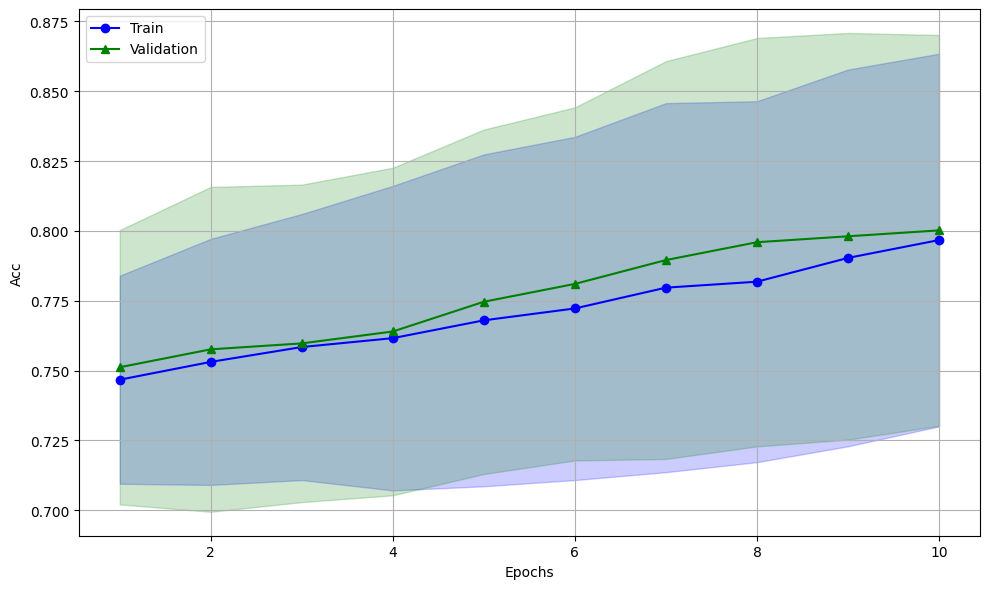

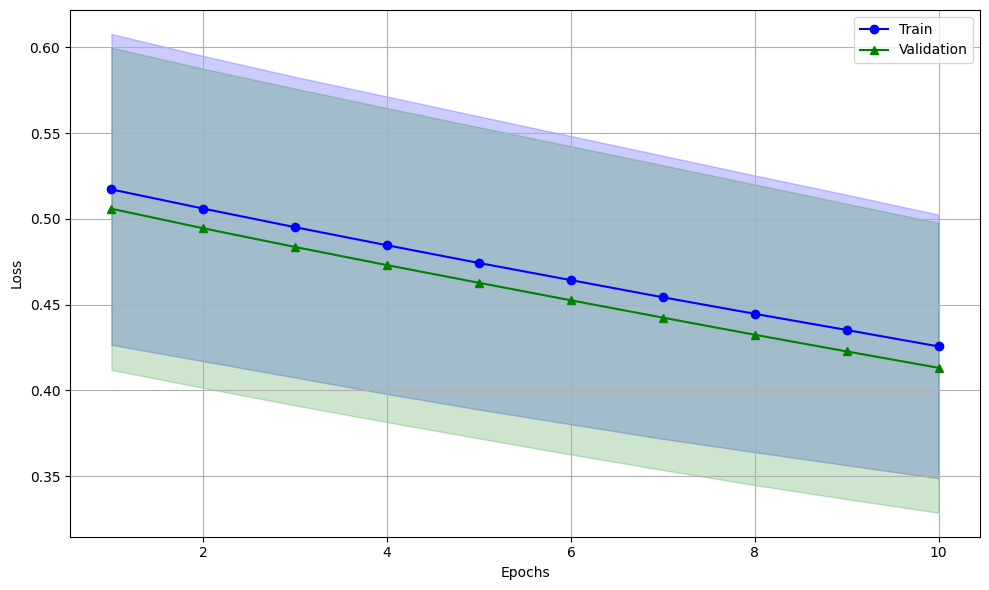

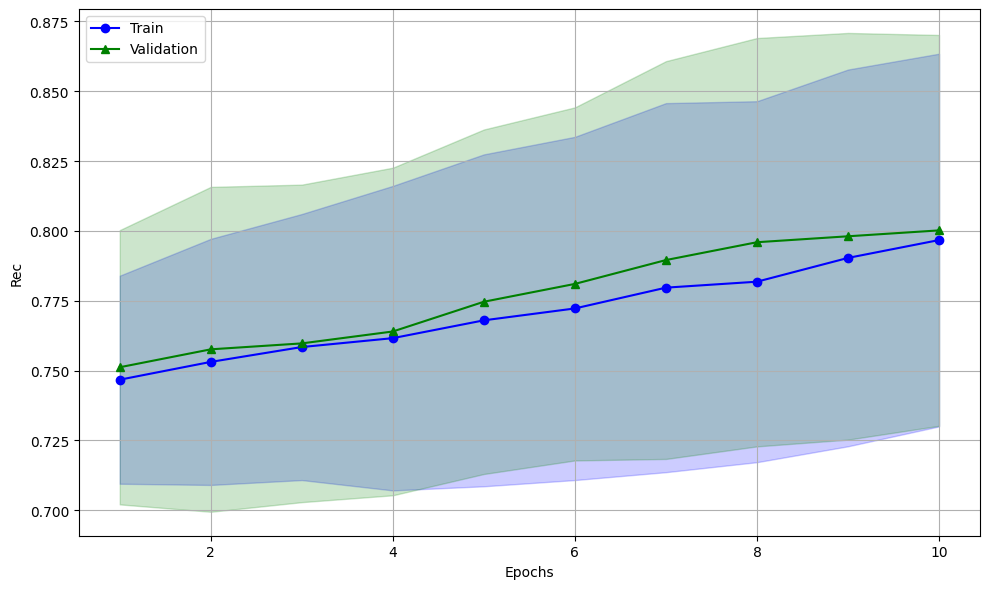

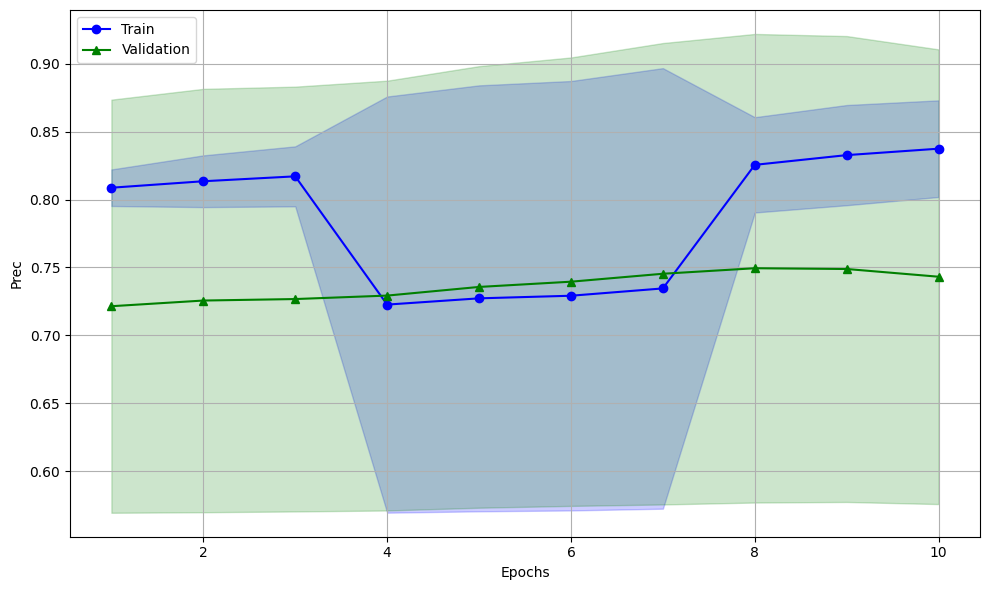

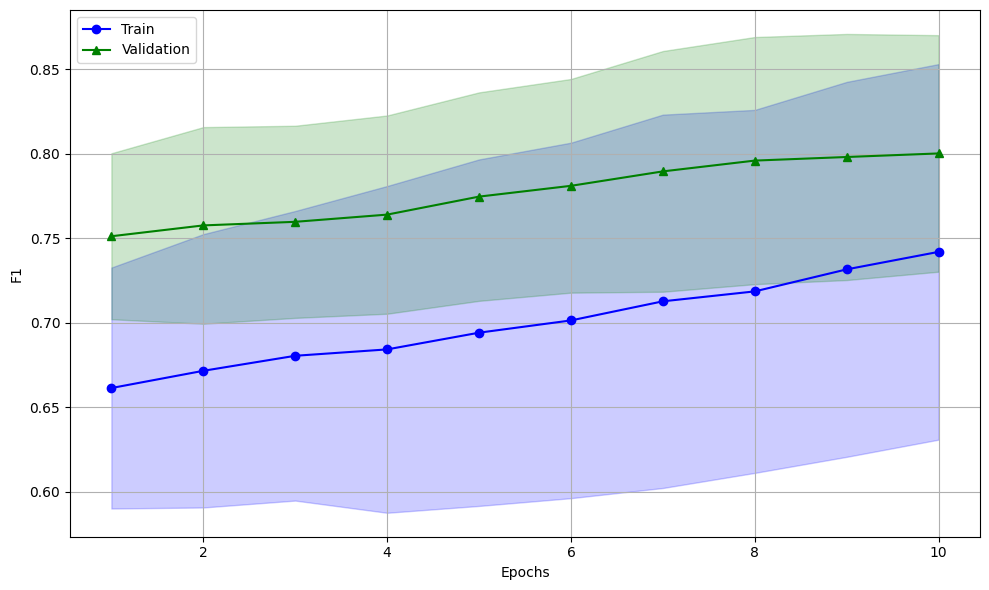

In [48]:
epochs_range = list(range(1, len(train_metrics_folds["acc"][0]) + 1))

metrics_summary = {}

for metric in ["acc", "loss", "rec", "prec", "f1"]:
    summary = plot_metric_with_std(metric, train_metrics_folds, val_metrics_folds, epochs_range)
    metrics_summary[metric] = summary

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_means_stds_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

In [49]:
# c_train_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }
# c_val_metrics = {
#     "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
# }

# best_val_f1 = 0

# for epoch in range(epochs):
#     print(f"epoch {epoch+1}/{epochs}")
#     # train_loss, train_acc = train(classical_model, train_loader, optimizer, criterion, device)
#     train_loss, train_acc, train_prec, train_rec, train_f1, c_train_report = train_v2(classical_model, train_loader, optimizer, criterion, device)
#     # val_loss, val_acc = evaluate(classical_model, val_loader, criterion, device)
#     val_loss, val_acc, val_prec, val_rec, val_f1, c_val_report, val_preds, val_probs, val_labels = evaluate_v2(classical_model, val_loader, criterion, device)

#     c_train_metrics["acc"].append(train_acc)
#     c_train_metrics["loss"].append(train_loss)
#     c_train_metrics["rec"].append(train_rec)
#     c_train_metrics["prec"].append(train_prec)
#     c_train_metrics["f1"].append(train_f1)
        
#     c_val_metrics["acc"].append(val_acc)
#     c_val_metrics["loss"].append(val_loss)
#     c_val_metrics["rec"].append(val_rec)
#     c_val_metrics["prec"].append(val_prec)
#     c_val_metrics["f1"].append(val_f1)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(classical_model.state_dict(), "/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth")


#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


#     tqdm.write(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Train rec: {train_rec:.4f} | Train prec: {train_prec:.4f} | Train f1: {train_f1:.4f}")
#     tqdm.write(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val rec: {val_rec:.4f} | Val prec: {val_prec:.4f} | Val f1: {val_f1:.4f}")


# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_train_metrics.json", "w") as f:
#     json.dump(c_train_metrics, f, indent=4)

# with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_val_metrics.json", "w") as f:
#     json.dump(c_val_metrics, f, indent=4)
    
#     # print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")
#     # print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

In [50]:
# epochs = range(1, len(c_train_metrics["acc"]) + 1)

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, c_train_metrics["loss"], label="Train Loss", marker="o")
# plt.plot(epochs, c_val_metrics["loss"], label="Validation Loss", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)

# # plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
# plt.plot(epochs, c_train_metrics["acc"], label="Train Accuracies", marker="o")
# plt.plot(epochs, c_val_metrics["acc"], label="Validation Accuracies", marker="^")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)    

# plt.tight_layout()
# plt.show()

In [51]:
best_fold = -1
best_val_f1 = -1

for fold in range(1, n_folds+1):
    with open(f"/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_{fold}_metrics.pkl", "rb") as f:
        train_metrics, val_metrics = pickle.load(f)

    last_val_f1 = val_metrics["f1"][-1]

    if last_val_f1 > best_val_f1:
        best_val_f1 = last_val_f1
        best_fold = fold

print(f"Best fold: {best_fold} with val_f1 = {best_val_f1:.4f}")

Best fold: 3 with val_f1 = 0.8846


In [52]:
test_classical_model = ClassicalModel()
# test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_model_best.pth"))
test_classical_model.load_state_dict(torch.load("/home/dalopezm/quantum-studies/quantum-cv/model_checkpoints/classical_fold_1_best.pth"))
test_classical_model.to(device)

c_test_metrics = {
    "acc": [], "loss": [], "rec": [], "prec": [], "f1": []
}

test_loss, test_acc, test_prec, test_rec, test_f1, test_report, test_preds, test_probs, test_labels = evaluate_v2(test_classical_model, test_loader, criterion, device)

c_test_metrics["acc"].append(test_acc)
c_test_metrics["loss"].append(test_loss)
c_test_metrics["rec"].append(test_rec)
c_test_metrics["prec"].append(test_prec)
c_test_metrics["f1"].append(test_f1)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test rec: {test_rec:.4f} | Test prec: {test_prec:.4f} | Test f1: {test_f1:.4f}")

with open("/home/dalopezm/quantum-studies/quantum-cv/results/classical_test_metrics.json", "w") as f:
    json.dump(c_test_metrics, f, indent=4)

Training: 100%|███████| 20/20 [00:00<00:00, 285.14it/s, loss=0.6079, acc=0.6250]

Test loss: 0.6079 | Test acc: 0.6250 | Test rec: 0.6250 | Test prec: 0.3906 | Test f1: 0.6250


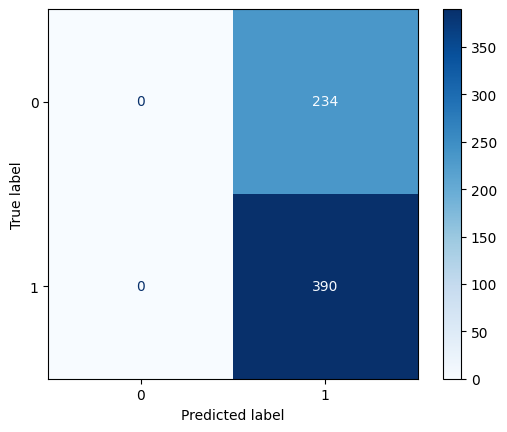

In [53]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

AUROC: 0.8861604207758054


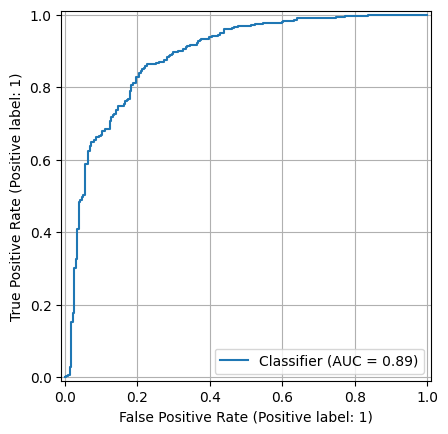

In [54]:
all_probs_np = np.array(test_probs)
all_labels_np = np.array(test_labels)

auroc = roc_auc_score(all_labels_np, all_probs_np[:,1])
print("AUROC:", auroc)

RocCurveDisplay.from_predictions(all_labels_np, all_probs_np[:,1])
plt.grid()
plt.show()

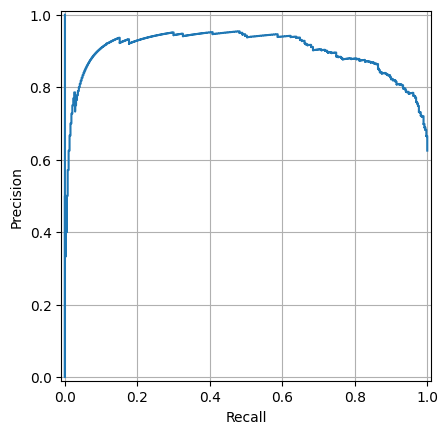

In [55]:

y_true = np.array(test_labels)
y_scores = np.array(test_probs)[:, 1]

precision, recall, _ = precision_recall_curve(y_true, y_scores)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.grid(True)
plt.show()